In [1]:
# 다중 입출력을 위한 데이터 생성하기

import numpy as np

# 햄버거 이미지
hamburger_img = np.random.random((1000, 28, 28, 1))
# 햄버거에 대한 평가
customer_form = np.random.randint(10000, size = (1000, 100))

# 햄버거에 대한 평점
hamburger_rate = np.round(np.random.random((1000,)) * 5, 1)
# 햄버거에 추가되어질 50가지의 재료
update_for_hamburger = np.random.randint(50, size = (1000,))

print(hamburger_img.shape, customer_form.shape)
print(hamburger_rate.shape, update_for_hamburger.shape)

(1000, 28, 28, 1) (1000, 100)
(1000,) (1000,)


In [5]:
# 다중 입출력 모델 구성하기

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.layers import Dense, Concatenate

# 각 입력에 대한 형태를 명시합니다.
img_input = Input(shape = (28, 28, 1), name = 'hambuger_img')
form_input = Input(shape = (None, ), name = 'customer_form')

# 햄버거 이미지 입력
x_1 = Conv2D(32, (3, 3), activation = 'relu')(img_input)
x_1 = Conv2D(32, (3, 3), activation = 'relu')(x_1)
x_1 = MaxPooling2D(strides = 2)(x_1)
x_1 = GlobalAveragePooling2D()(x_1)

# 햄버거에 대한 평가 입력
x_2 = Embedding(10000, 64)(form_input)
x_2 = LSTM(128)(x_2)

# 출력을 만들기 위해 모든 입력을 하나의 텐서로 합칩니다.
x = Concatenate()([x_1, x_2])

# 햄버거 평점에 대한 출력값
rate_pred = Dense(1, name = 'hamburger_rate')(x)

# 보완될 50가지 재료에 대한 출력값
update_pred = Dense(50, activation = 'softmax',
                    name = 'update_for_hamburger')(x)

# 모델을 생성합니다.
model = Model(inputs = [img_input, form_input],
              outputs = [rate_pred, update_pred])

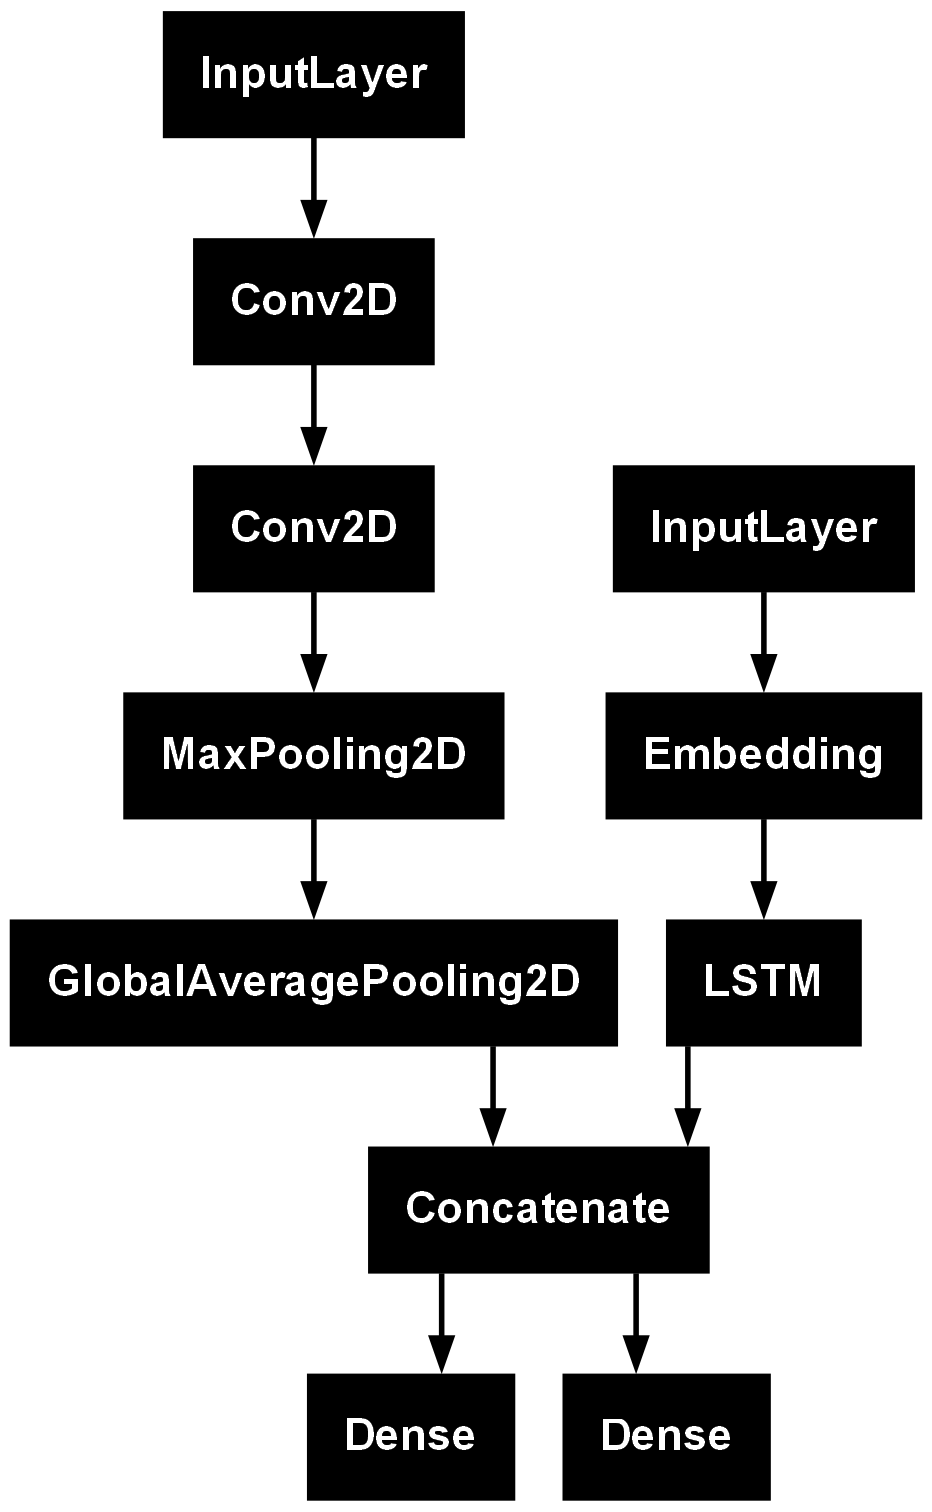

In [6]:
# 모델 구조 그려보기
from tensorflow.keras.utils import plot_model
plot_model(model)

In [7]:
# 모델 구조 확인하기
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ hambuger_img        │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 26, 26,    │        320 │ hambuger_img[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ customer_form       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 12, 12,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 64)  │    640,000 │ customer_form[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │     98,816 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hamburger_rate      │ (None, 1)         │        161 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ update_for_hamburg… │ (None, 50)        │      8,050 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 756,595 (2.89 MB)

 Trainable params: 756,595 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 다중 입출력 모델에서 학습 과정 설정하기

# 손실함수에 리스트 형태를 사용한 경우
"""
model.compile(optimizer = 'adam',
              loss = ['mse', 'sparse_categorical_crossentropy],
              metrics = {'hamburger_rate':'mse', 'update_for_hamburger':'acc'})
"""

# 또는

# 손실함수에 딕셔너리 형태를 사용한 경우

model.compile(optimizer = 'adam',
              loss = {'hamburger_rate':'mse',
                      'update_for_hamburger':'sparse_categorical_crossentropy'},
              metrics = {'hamburger_rate':'mse', 'update_for_hamburger':'acc'})

In [10]:
# 다중 입출력 모델 학습하기

# 모델 학습에 리스트 형태를 사용한 경우
"""
model.fit([hamburger_img, customer_form],
          [hamburger_rate, update_for_hamburger],
          epochs = 2, batch_size = 32)
"""

# 또는

# 모델 학습에 딕셔너리형태를 상용한 경우
model.fit({'hamburger_img':hamburger_img, 'customer_form':customer_form},
          {'hamburger_rate':hamburger_rate,
           'update_for_hamburger':update_for_hamburger},
           epochs = 2, batch_size = 32)

Epoch 1/2


ValueError: Missing data for input "hambuger_img". You passed a data dictionary with keys ['hamburger_img', 'customer_form']. Expected the following keys: ['hambuger_img', 'customer_form']